In [40]:
import json
import pandas as pd
import numpy as np
from kneed import KneeLocator
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [41]:
# -----------------------------
# Step 1: Load JSON
# -----------------------------
with open('user_preferences.json', 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data)
processed_df = df.copy()

In [42]:
# -----------------------------
# Step 2: Separate columns
# -----------------------------
# Identify drinking preference columns (exclude from clustering)
drinking_cols = ['mocktail', 'juice', 'cocktail', 'alcohol']

# Clustering-relevant preference columns
preference_cols = [col for col in df.columns if col not in ['name', 'diet', 'drink_preferences']]
# Flatten the drink_preferences nested dict into separate columns
for drink_col in drinking_cols:
    processed_df[drink_col] = processed_df['drink_preferences'].apply(lambda x: x.get(drink_col, None))


# Scale only clustering-relevant columns
X = processed_df[preference_cols]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [43]:
# -----------------------------
# Step 3: Determine optimal number of clusters (k)
# -----------------------------
inertias = []
sil_scores = []
K_range = range(2, min(7, len(df)))

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

knee = KneeLocator(K_range, inertias, curve="convex", direction="decreasing")
best_k_elbow = knee.knee
best_k_silhouette = K_range[sil_scores.index(max(sil_scores))]

if best_k_elbow is None:
    best_k = best_k_silhouette
else:
    best_k = best_k_silhouette if abs(best_k_elbow - best_k_silhouette) <= 1 else best_k_elbow

print(f"Chosen number of clusters (k) = {best_k}")

Chosen number of clusters (k) = 4


In [44]:
# -----------------------------
# Step 4: Final K-Means clustering
# -----------------------------
kmeans_final = KMeans(n_clusters=best_k, random_state=42)
processed_df['cluster'] = kmeans_final.fit_predict(X_scaled)

In [45]:
# -----------------------------
# Step 5: Cluster assignments
# -----------------------------
print("\nCluster Assignments:\n")
print(processed_df[['name', 'cluster'] + preference_cols + ['diet']])


Cluster Assignments:

      name  cluster  hunger_level  spice_level  indian_craving  \
0    Alice        3             5            4               5   
1      Bob        2             2            1               1   
2  Charlie        1             4            5               2   
3    David        0             3            2               1   
4      Eve        2             1            1               2   
5    Frank        1             5            5               5   
6   Hannah        2             2            3               1   
7      Ian        3             4            3               4   
8     Kate        0             3            4               3   
9      Leo        1             5            5               5   

   pan_asian_craving  italian_craving  mexican_craving  american_craving  \
0                  2                3                1                 4   
1                  4                5                2                 3   
2                  5  

In [46]:
# -----------------------------
# Step 6: Detailed cluster analysis + store in JSON
# -----------------------------
cluster_summary = []

for cluster_id in sorted(processed_df['cluster'].unique()):
    cluster_data = processed_df[processed_df['cluster'] == cluster_id]
    
    # Member names
    members = list(cluster_data['name'])
    
    # Diet breakdown
    diet_counts = {str(k): int(v) for k, v in cluster_data['diet'].value_counts().to_dict().items()}
    
    # Cuisine cravings in descending order
    cuisine_cols = [col for col in preference_cols if '_craving' in col]
    cuisine_avgs = cluster_data[cuisine_cols].mean().sort_values(ascending=False)
    cuisine_avgs_dict = {str(k): round(float(v), 2) for k, v in cuisine_avgs.to_dict().items()}
    
    # Other numeric preferences
    other_cols = [col for col in preference_cols if col not in cuisine_cols]
    other_avgs = cluster_data[other_cols].mean().sort_values(ascending=False)
    other_avgs_dict = {str(k): round(float(v), 2) for k, v in other_avgs.to_dict().items()}
    
    # Drinking preferences (individual-level)
    drinks_data = cluster_data[['name'] + drinking_cols].set_index('name').to_dict(orient='index')
    
    cluster_summary.append({
        "cluster_id": int(cluster_id),
        "members": members,
        "diet_breakdown": diet_counts,
        "cuisine_craving_averages": cuisine_avgs_dict,
        "average_preferences": other_avgs_dict,
        "individual_drinking_preferences": drinks_data
    })

# Save final cluster summary to JSON
with open("cluster_summary.json", "w") as f:
    json.dump(cluster_summary, f, indent=4)

print("Cluster summary saved to 'cluster_summary.json'")

Cluster summary saved to 'cluster_summary.json'


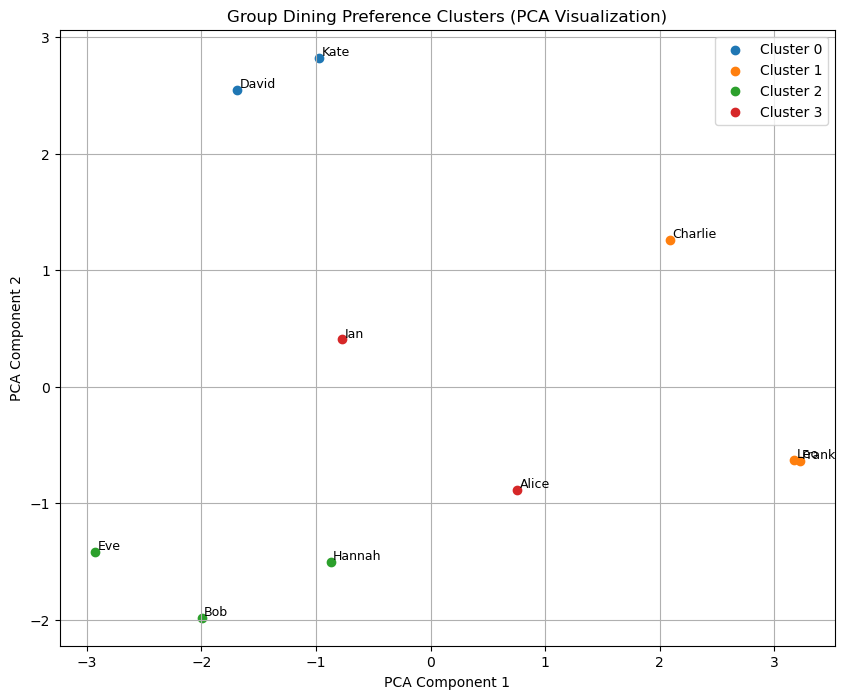

In [47]:
# -----------------------------
# Step 7: PCA visualization
# -----------------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

viz_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
viz_df['cluster'] = processed_df['cluster']
viz_df['name'] = processed_df['name']

plt.figure(figsize=(10, 8))
for cluster_id in sorted(viz_df['cluster'].unique()):
    cluster_data = viz_df[viz_df['cluster'] == cluster_id]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f"Cluster {cluster_id}")

# Label points with user names
for i, row in viz_df.iterrows():
    plt.text(row['PCA1'] + 0.02, row['PCA2'] + 0.02, row['name'], fontsize=9)

plt.title("Group Dining Preference Clusters (PCA Visualization)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()
